# Classifying Cygnus X-1 Hardness-Intensity diagrams (HIDs)

- needs to be easy to do for people with no knowledge
- more than ASM data
- all RXTE observations (pointed: HEXTE, PCA)
- all sky monitor observations: MAXI, Swift/BAT, Fermi/GBM, RXTE ASM
- pointed obs: spectra, time series (lags, variability=rms)
- state definition based on pointed observations (states: hard, soft intermediate, IM could also be two)
- RXTE ASM obs for all pointed obs, look at location in HID --> cuts in HID based on pointed observations

- how stable are the individual states?
- what's the correlation length of a state? --> given an observation, will it still be in the same state after X hours?
- after X hours, what's the probability that a source has done a transition after X hours?

Questions:
1. original classification using pointed observations. Can you find *three* classes in the ASM data only?
2. for another all-sky monitor without pointed obs, can we use the HID to classify states? For example, for MAXI we have little overlapping data, but lots of non-overlapping data. Can we use the ASM to do the classification with MAXI?
3. Can we *only* do a MAXI classification?
4. Can we classify it with HID only, or are we going to do massively better if we use colour-colour diagrams and HIDs together?
5. Can we separate absorption dips?


Strategy:
Supervised learning
1. Supervised learning on classified ASM data: can we do as well on the pointed observations as a human?
2. Do we do better in 3D if we add more colour information?
3. Can we classify the MAXI data based on the ASM classification even though the data are different?

Unsupervised Learning
1. Clustering on HID (*ALL* data) alone: how many clusters do we need to explain the data? (KMeans, GMM)
2. Do we do better in 3D if we add colour information? Also orbital phase?
3. Do we do better with even more information if we add timing information if we use pointed observations?


## Supervised Learning

We're going to start with the supervised learning part on the small data set only. We're going to extract training, validation and test sets with $60\%$, $20\%$ and $20\%$, respectively, and we're going to ignore orbits for now.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=2.5, rc={"axes.labelsize": 26})
plt.rc("font", size=24, family="serif", serif="Computer Sans")
plt.rc("axes", titlesize=20, labelsize=20) 
plt.rc("text", usetex=True)

import numpy as np
import generaltools as gt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cmap
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model 




The RXTE/ASM data are in the file `asm_with_states_ml.txt`. The columns of this file are:
1. total Rate
2. rate in 1.5-3.0 keV (ASM band A)
3. rate in 3.0-5.0 keV (ASM band B)
4. rate in 5.0-12.0 keV (ASM band C)
5. state (1 = hard, 2 = intermediate, 3 = soft, 0 = no state measured)
6. orbital phase

Hardness intensity diagram is formed by dividing ASM band C by ASM band A (hardness) and using the total rate as intensity. 
We will first attempt it with HID, then we might add other features.

This file contains *all* ASM measurements, both the classified ones and the unclassified ones. For this first part, we'll only use the classified ones (state > 0), so the first step is to extract them out of the data file.

In [2]:
data = np.loadtxt("asm_with_states_ml.txt")

## find all rows where the data has classes
class_ind = np.where(data[:,4] > 0)[0]
print(len(class_ind))
data_class = data[class_ind]


## shuffle data to separate out train, validation and test sets
np.random.shuffle(data_class)

## our features are actually going to be hardness and intensity
intensity = np.log(data_class[:,0])
hardness = np.log(data_class[:,3]/data_class[:,1])

features_all = np.transpose(np.array([hardness, intensity, data_class[:,4]]))

## define variables for splitting the data set into training, validation and test set
n_data = data_class.shape[0] ## total number of data points
train_frac = 0.6 ## training fraction
val_frac = 0.2 ## validation fraction
test_frac = 0.2 ## test fraction

## extract training, validation and test sets
d_train = features_all[:int(train_frac*n_data)]
d_val = features_all[int(train_frac*n_data):int((train_frac + val_frac)*n_data)]
d_test = features_all[int((train_frac + val_frac)*n_data):]

## extract training, validation and test set features
f_all = features_all[:,:2]
f_train = d_train[:,:2]
f_val = d_val[:,:2]
f_test = d_test[:,:2]

## extract labels for training, validation and test sets
l_train = d_train[:,2]
l_val = d_val[:,2]
l_test = d_test[:,2]

#features = data[:,:2]
#orbits = data[:,3]
#features_ind = np.where((0.25 <= orbits) & (orbits <= 0.75))
#labels = data[:,2]

2400


Okay, now we can scale the features to unit mean and variance. We're going to train the StandardScaler on *all* data, then transform train, validation and test sets separately.

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(f_all)

fscaled_train = scaler.transform(f_train)
fscaled_val = scaler.transform(f_val)
fscaled_test = scaler.transform(f_test)


Let's start with dumb K-Nearest Neighbor for our supervised learning task. 

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

params = {'n_neighbors': [1, 3, 5, 10, 15, 20, 25, 30, 50, 75, 100, 150, 200]}#, 'max_features': }
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid=params, verbose=1, n_jobs=10)
grid_knn.fit(fscaled_train, l_train)


Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  21 out of  39 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  39 out of  39 | elapsed:    0.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=10,
       param_grid={'n_neighbors': [1, 3, 5, 10, 15, 20, 25, 30, 50, 75, 100, 150, 200]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

Let's find out how we've done:

In [8]:
print(grid_knn.best_params_)
print(grid_knn.score(fscaled_train, l_train))
print(grid_knn.score(fscaled_val, l_val))
labels_knn = grid_knn.predict(fscaled_val)


{'n_neighbors': 100}
0.948611111111
0.9375


So $~95\%$ on the first try seems pretty good. Let's plot a confusion matrix and see where the confusions are. 

[[312   8   2]
 [ 15  66   3]
 [  0   2  72]]
[ 1.  2.  3.]


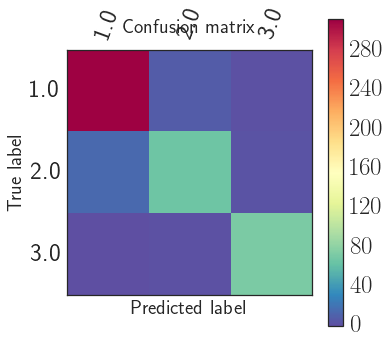

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cmap

sns.set_style("white") 
unique_labels = np.unique(l_val)
cm = confusion_matrix(l_val, labels_knn, labels=unique_labels)
print(cm)
print(unique_labels)
plt.matshow(cm, cmap=cmap.Spectral_r )
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
plt.yticks(range(len(unique_labels)), unique_labels)
plt.show()

Let's try a random forest, because random forests are awesome.

In [10]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth': [1,3,5,6,7,8,9,10, 11,12,13,14,15,16,17, 18, 19, 20, 21, 22, 23, 25,30,40]}

grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=500), param_grid=params, 
                        verbose=1, n_jobs=10)
grid_rfc.fit(fscaled_train, l_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  50 jobs       | elapsed:   11.4s
[Parallel(n_jobs=10)]: Done  54 out of  72 | elapsed:   13.3s remaining:    4.4s
[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed:   16.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=10,
       param_grid={'max_depth': [1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

{'max_depth': 5}
0.959722222222
0.933333333333
[[310  12   1]
 [ 13  66   2]
 [  0   4  72]]
[ 1.  2.  3.]


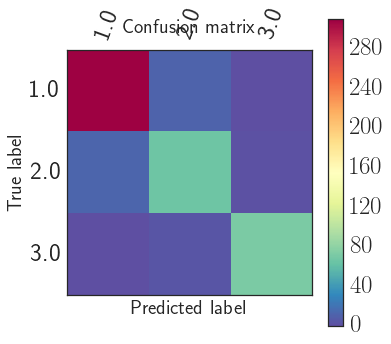

In [8]:
print(grid_rfc.best_params_)
print(grid_rfc.score(fscaled_train, l_train))
print(grid_rfc.score(fscaled_val, l_val))
labels_rfc = grid_rfc.predict(fscaled_val)
labels_train_rfc = grid_rfc.predict(fscaled_train)

sns.set_style("white") 
unique_labels = np.unique(l_val)
cm = confusion_matrix(l_val, labels_rfc, labels=unique_labels)
print(cm)
print(unique_labels)
plt.matshow(cm, cmap=cmap.Spectral_r )
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
plt.yticks(range(len(unique_labels)), unique_labels)
plt.show()

Again, around $94\%$. What about linear models?

In [9]:
from sklearn import linear_model 


params = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_lm = GridSearchCV(linear_model.LogisticRegression(penalty="l1", class_weight="auto"), 
                    param_grid=params, verbose=1, n_jobs=10)
grid_lm.fit(fscaled_train, l_train)




#sgd = linear_model.SGDClassifier(loss='modified_huber', penalty="elasticnet", shuffle=False,
#                                 n_jobs = -1)
#sgd.fit(features_train, labels_train)
#print(sgd.score(features_test, labels_test))




Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  18 | elapsed:    0.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='auto', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0),
       fit_params={}, iid=True, loss_func=None, n_jobs=10,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

In [10]:
print(grid_lm.best_params_)
print(grid_lm.score(fscaled_train, l_train))
print(grid_lm.score(fscaled_val, l_val))
labels_lm = grid_lm.predict(fscaled_val)

{'C': 100}
0.930555555556
0.929166666667


All models have about $95\%$ accuracy. None of them manage to learn the training set completely. Does that mean there may be some confusion in the training set? Perhaps some outliers? For the random forest, I'm going to plot the data points with intrinsic classes, and plot the confused data points in blue.

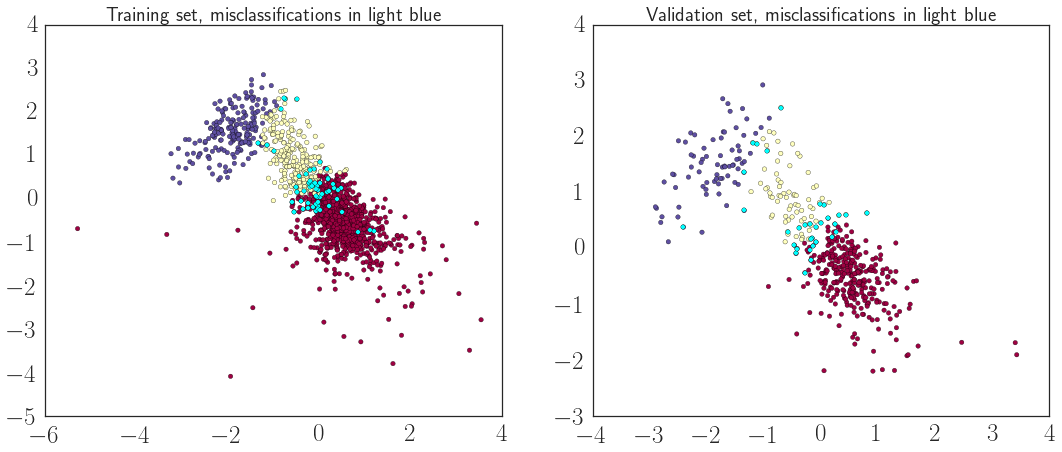

In [11]:
fig = plt.figure(figsize=(18,7))
ax = fig.add_subplot(121)
ax.scatter(fscaled_train[:,0], fscaled_train[:,1], c=labels_train_rfc, cmap=cmap.Spectral)
misclass_train_ind = np.where(l_train != labels_train_rfc)[0]
ax.scatter(fscaled_train[misclass_train_ind,0], fscaled_train[misclass_train_ind,1], c="cyan")
ax.set_title("Training set, misclassifications in light blue")

ax2 = fig.add_subplot(122)
ax2.scatter(fscaled_val[:,0], fscaled_val[:,1], c=labels_rfc, cmap=cmap.Spectral)
misclass_ind = np.where(l_val != labels_rfc)[0]
ax2.scatter(fscaled_val[misclass_ind,0], fscaled_val[misclass_ind,1], c="cyan")
ax2.set_title("Validation set, misclassifications in light blue")


Most of these misclassifications are at the intersection of hard and intermediate state. Could this be that there are genuinely data points that lie between the two? Is this boundary just not very clear? Who knows? :)
This is my favourite interpretation, given that we can't learn the training set perfectly, but I may be missing something.

## Does Adding More Features Help?

One of the things we can do is add another dimension, i.e. another colour. This might help separate things out, but makes the whole thing slightly more complex, too. We're going to try first to define the other colour as ASM band B divided by ASM band A, but we should also try ASM band C divided by ASM band B.

In [11]:
#data = np.loadtxt("asm_with_states_ml.txt")

## find all rows where the data has classes
#class_ind = np.where(data[:,4] > 0)[0]
#print(len(class_ind))
#data_class = data[class_ind]


## shuffle data to separate out train, validation and test sets
#np.random.shuffle(data_class)

## our features are actually going to be hardness and intensity
intensity = data_class[:,0]
hardness = data_class[:,3]/data_class[:,1]
hardness2 = data_class[:,3]/data_class[:,2]

features_all = np.transpose(np.array([hardness,hardness2, intensity, data_class[:,4]]))

## define variables for splitting the data set into training, validation and test set
n_data = data_class.shape[0] ## total number of data points
train_frac = 0.6 ## training fraction
val_frac = 0.2 ## validation fraction
test_frac = 0.2 ## test fraction

## extract training, validation and test sets
d_train = features_all[:int(train_frac*n_data)]
d_val = features_all[int(train_frac*n_data):int((train_frac + val_frac)*n_data)]
d_test = features_all[int((train_frac + val_frac)*n_data):]

## extract training, validation and test set features
f_all = features_all[:,:3]
f_train = d_train[:,:3]
f_val = d_val[:,:3]
f_test = d_test[:,:3]

## extract labels for training, validation and test sets
l_train = d_train[:,3]
l_val = d_val[:,3]
l_test = d_test[:,3]

scaler = StandardScaler().fit(f_all)

fscaled_train = scaler.transform(f_train)
fscaled_val = scaler.transform(f_val)
fscaled_test = scaler.transform(f_test)

#features = data[:,:2]
#orbits = data[:,3]
#features_ind = np.where((0.25 <= orbits) & (orbits <= 0.75))
#labels = data[:,2]

In [12]:
print(fscaled_train.shape)

(1440, 3)


In [13]:
import utils
reload(utils)
grid_knn, grid_rfc, grid_lm = utils.supervised_class(fscaled_train, fscaled_val, l_train, l_val)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
I have finished KNN classification. RFC is next.
Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done   9 out of  27 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  27 out of  27 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done  50 jobs       | elapsed:   12.1s
[Parallel(n_jobs=10)]: Done  54 out of  72 | elapsed:   14.0s remaining:    4.7s
[Parallel(n_jobs=10)]: Done  72 out of  72 | elapsed:   17.7s finished


I have finished RFC classification. Linear Regression is next.
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done  18 out of  18 | elapsed:    0.1s finished


K-Nearest Neighbour Classification Results:

{'n_neighbors': 30}
0.942361111111
0.93125
Random Forest Classifier Results:

{'max_depth': 3}
0.95
0.933333333333
Linear SVC Classifier Results:

{'C': 100}
0.944444444444
0.939583333333


For adding either of the hardness ratios, the accuracy doesn't really increase. That's okay, because physically they don't necessarily add any information, since they other ratio doesn't measure an independent component. 

## Can we Classify the MAXI data using a model trained on ASM data?

There is a lot of data taken with MAXI after RXTE/ASM shut off, for which we don't have accurate timing or spectral information. The question is whether we can use train a classification algorithm on the ASM data set, and then use it on the MAXI data set, despite the differences between the two instruments. My feeling is that the fact that we're scaling to standard mean and variance may save us, but I'm not sure.

We're going to try to compute a scaling transformation for the ASM and MAXI independently, then predict labels based on the ASM training set.


In [30]:
## RXTE/ASM DATA
data = np.loadtxt("asm_with_states_ml.txt")

## find all rows where the data has classes
class_ind = np.where(data[:,4] > 0)[0]
print(len(class_ind))
data_class = data[class_ind]

## shuffle data to separate out train, validation and test sets
np.random.shuffle(data_class)

## our features are actually going to be hardness and intensity
intensity = data_class[:,0]
hardness = data_class[:,3]/data_class[:,1]

features_train = np.transpose(np.array([hardness, intensity, data_class[:,4]]))


f_all = features_train[:,:2]
l_all = features_train[:,2]


2400


Reading in MAXI data. Columns are:

1. MAXI total rate (2-20 keV)
2. MAXI 2-4 keV rate
3. MAXI 4-10 keV rate
4. MAXI 10-20 keV rate
5. state (1 hard, 2 intermediate, 3 soft, 4 no state classification)
6. orbital phase


In [42]:
maxi_data = np.loadtxt("maxi_with_states_ml.txt")
print("There are %i samples in the MAXI data set."%len(maxi_data))
## find all rows where the data has classes
class_ind = np.where(maxi_data[:,4] > 0.)[0]
maxi_data_class = maxi_data[class_ind]
print("There are %i samples in the classified MAXI data set."%len(maxi_data_class))

## shuffle data to separate out train, validation and test sets
np.random.shuffle(maxi_data_class)

## our features are actually going to be hardness and intensity
intensity = maxi_data_class[:,0]
hardness = maxi_data_class[:,2]/maxi_data_class[:,1]

features_test = np.transpose(np.array([hardness, intensity, maxi_data_class[:,4]]))

maxi_features_all = np.transpose(np.array([maxi_data[:,0],
                                          maxi_data[:,2]/maxi_data[:,1]]))

#f_train = np.concatenate((f_all, features_test[:60,:2]))
#l_train = np.concatenate((l_all, features_test[:60,2]))

f_test = features_test[:,:2]#[60:,:2]
l_test = features_test[:,2]#[60:,2]


There are 16460 samples in the MAXI data set.
There are 126 samples in the classified MAXI data set.


We are going to scale ASM and MAXI data independently. We should use *all* data for scaling (classified and unclassified), but then only use the classified data as a test set:

In [43]:
scaler = StandardScaler().fit(f_train)

fscaled_train = scaler.transform(f_train)

scaler_maxi = StandardScaler().fit(maxi_features_all)
fscaled_test = scaler.transform(f_test)
#fscaled_test[:,0] = fscaled_test[:,0]#*2.0-1.0

Now we train a random forest on the entire data set.

In [44]:
from sklearn.ensemble import RandomForestClassifier

params = {'max_depth': [7,8,9,10, 12,14,16,18, 19, 20, 21, 23, 25,30,40]}

grid_rfc = GridSearchCV(RandomForestClassifier(n_estimators=100), param_grid=params, 
                        verbose=1, n_jobs=10)
grid_rfc.fit(fscaled_train, l_train)


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[Parallel(n_jobs=10)]: Done   1 jobs       | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done  45 out of  45 | elapsed:    2.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=10,
       param_grid={'max_depth': [7, 8, 9, 10, 12, 14, 16, 18, 19, 20, 21, 23, 25, 30, 40]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=1)

{'max_depth': 12}
Train score: 0.99918699187
Test score: 0.968253968254
[[57  2  0]
 [ 1  7  0]
 [ 1  0 58]]
[ 1.  2.  3.]


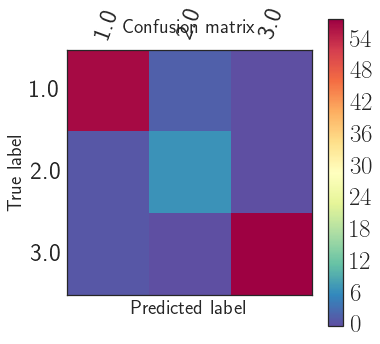

In [45]:
print(grid_rfc.best_params_)
print("Train score: " + str(grid_rfc.score(fscaled_train, l_train)))
print("Test score: " + str(grid_rfc.score(fscaled_test, l_test)))

labels_rfc = grid_rfc.predict(fscaled_test)
labels_train_rfc = grid_rfc.predict(fscaled_train)

sns.set_style("white") 
unique_labels = np.unique(l_test)
cm = confusion_matrix(l_test, labels_rfc, labels=unique_labels)
print(cm)
print(unique_labels)
plt.matshow(cm, cmap=cmap.Spectral_r )
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
plt.yticks(range(len(unique_labels)), unique_labels)
plt.show()

It looks like this works surprisingly well! Scaling both data sets yields some pretty good test scores!

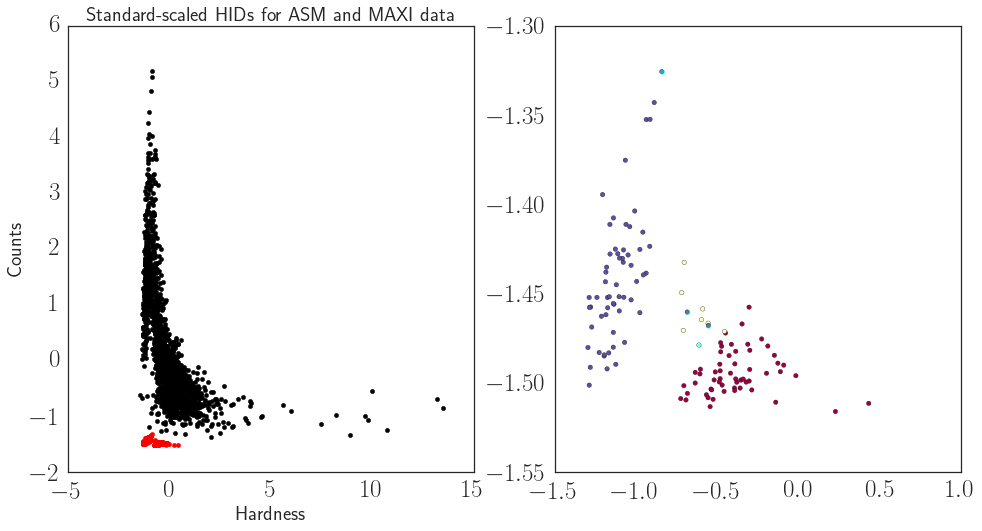

In [46]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.scatter(fscaled_train[:,0], fscaled_train[:,1], color="black")
ax.scatter(fscaled_test[:,0], fscaled_test[:,1], color="red")
ax.set_title("Standard-scaled HIDs for ASM and MAXI data")
ax.set_xlabel("Hardness")
ax.set_ylabel("Counts")

ax2 = fig.add_subplot(122)
ax2.scatter(fscaled_test[:,0], fscaled_test[:,1], c=l_test, cmap=cmap.Spectral)
misclass_ind = np.where(l_test != labels_rfc)
ax2.scatter(fscaled_test[misclass_ind,0], fscaled_test[misclass_ind,1], color="cyan", alpha=0.5)

#x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                     np.arange(y_min, y_max, h))
#Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
#Z = Z.reshape(xx.shape)
#plt.figure()
#plt.pcolormesh(xx, yy, Z, cmap=cmap_light)


In [47]:
class_ind = np.where(maxi_data[:,4] == 0.)[0]
maxi_data_noclass = maxi_data[class_ind]

## shuffle data
np.random.shuffle(maxi_data_noclass)

## our features are actually going to be hardness and intensity
intensity = np.log(maxi_data_noclass[:,0])
hardness = np.log(maxi_data_noclass[:,2]/maxi_data_noclass[:,1])

features_maxi = np.transpose(np.array([hardness, intensity, maxi_data_noclass[:,4]]))

notnan_ind = np.isnan(features_maxi)
features_maxi_clean = []
maxi_data_noclass_clean = []
for f,c,n in zip(features_maxi,maxi_data_noclass,notnan_ind):
    if any(n):
        continue
    else:
        features_maxi_clean.append(f)
        maxi_data_noclass_clean.append(f)

features_maxi_clean = np.array(features_maxi_clean)
maxi_data_noclass_clean = np.array(maxi_data_noclass_clean) 

f_maxi = features_maxi_clean[:,:2]
l_maxi = features_maxi_clean[:,2]
fscaled_maxi = scaler_maxi.transform(f_maxi)

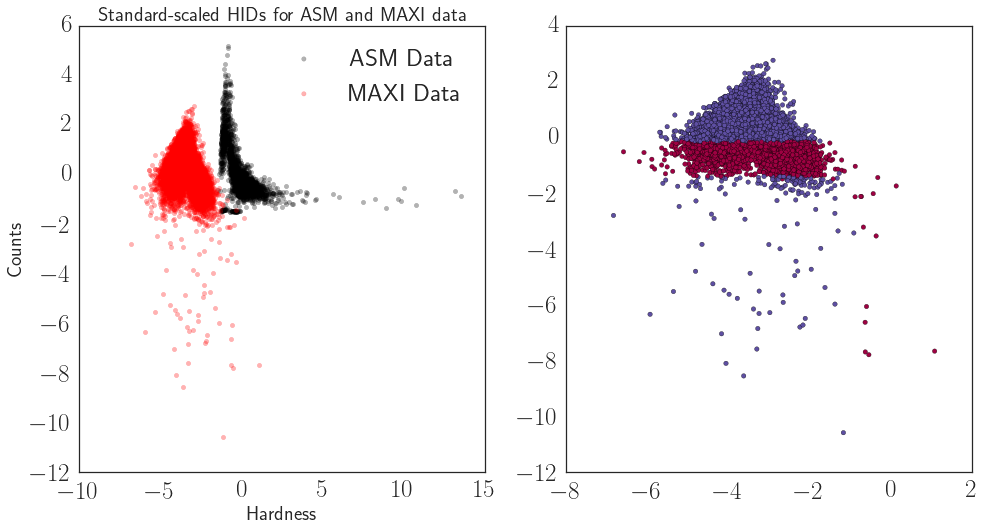

In [48]:
labels_maxi= grid_rfc.predict(fscaled_maxi)
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
ax.scatter(fscaled_train[:,0], fscaled_train[:,1], color="black", 
           alpha=0.3, label="ASM Data")
ax.scatter(fscaled_maxi[:,0], fscaled_maxi[:,1], color="red", 
           alpha=0.3, label="MAXI Data")
ax.set_title("Standard-scaled HIDs for ASM and MAXI data")
ax.set_xlabel("Hardness")
ax.set_ylabel("Counts")
ax.legend()

ax2 = fig.add_subplot(122)
ax2.scatter(fscaled_maxi[:,0], fscaled_maxi[:,1], c=labels_maxi, cmap=cmap.Spectral)
#misclass_ind = np.where(l_test != labels_rfc)
#ax2.scatter(fscaled_test[misclass_ind,0], fscaled_test[misclass_ind,1], color="cyan", alpha=0.5)


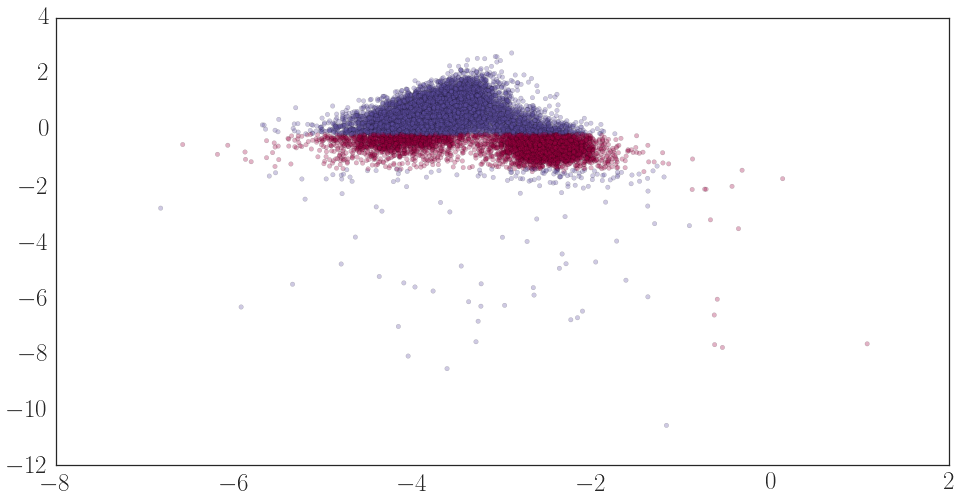

In [50]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.scatter(fscaled_maxi[:,0], fscaled_maxi[:,1], c=labels_maxi, cmap=cmap.Spectral, alpha=0.3)
#ax.set_xlim([-5,2])
#ax.set_ylim([-6,-1])

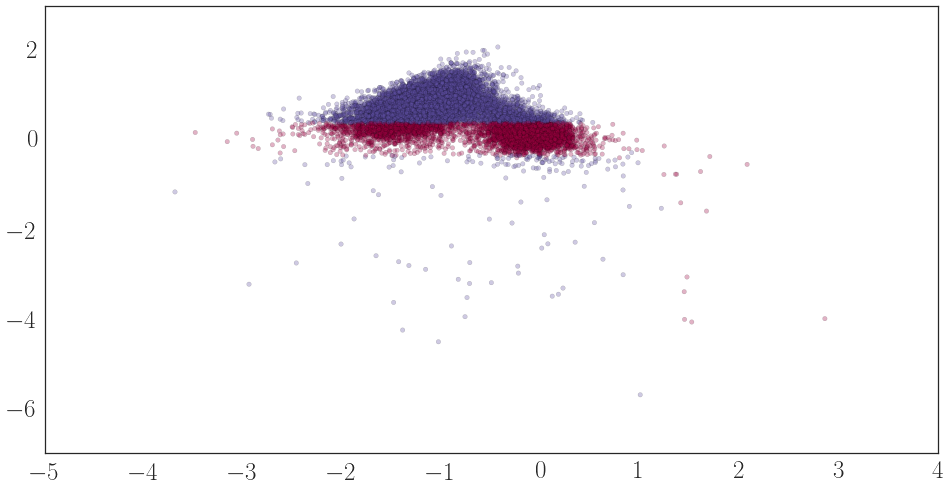

In [53]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.scatter(maxi_data_noclass_clean[:,0], maxi_data_noclass_clean[:,1], c=labels_maxi, cmap=cmap.Spectral, alpha=0.3)
#ax.set_xlim([-5,2])
#ax.set_ylim([-6,-1])

This seems to not classify any intermediate states. I wonder why this is! This could use some more thought, I think.

## K-Means clustering on the data where we have labels 

I.e. does the computer agree with the human? And how can we tell?

In [54]:
## scikit-learn stuff
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn import metrics


First, we're going to read in the data. First column is hardness, second column is count rate, third column contains labels for three states.

In [56]:
data = np.loadtxt("states_ml.txt")

In [58]:
features = data[:,:2]
orbits = data[:,3]
features_ind = np.where((0.25 <= orbits) & (orbits <= 0.75))
#features_ind = np.where(features[:,0] < 4.)
labels = data[:,2]

In [59]:
features = features[features_ind]
labels= labels[features_ind]
print(len(labels))

1194


In [60]:
scaler = StandardScaler().fit(features)
fscaled = scaler.transform(features)

1.0
4.0
Rand Index adjusted for chance: 0.305760928708


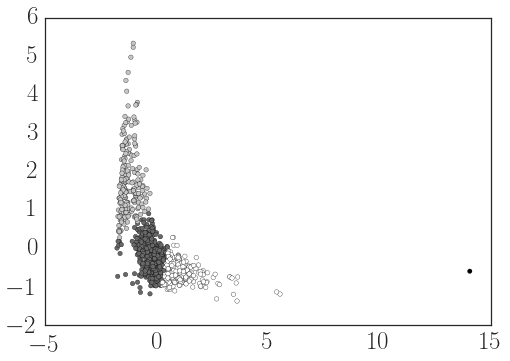

In [61]:
kmc = KMeans(init='k-means++', n_clusters=4, n_init=50)
kmc.fit(fscaled)
pred_labels = kmc.labels_+1.
print(np.min(pred_labels))
print(np.max(pred_labels))
print("Rand Index adjusted for chance: " + str(metrics.adjusted_rand_score(labels, pred_labels)))

plt.scatter(fscaled[:,0], fscaled[:,1], c=pred_labels)

1193
1194
[ 1.  2.  3.]


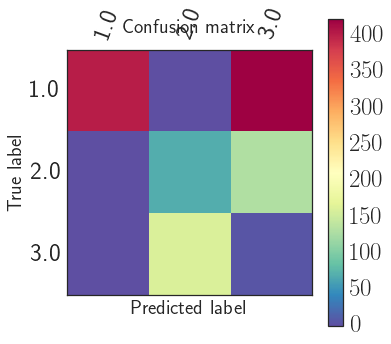

In [62]:
from sklearn.metrics import confusion_matrix
sns.set_style("white") 
unique_labels = np.unique(labels)
cm = confusion_matrix(labels, pred_labels, labels=unique_labels)
#print(cm)
print(np.sum(cm))
print(len(labels))
print(unique_labels)
plt.matshow(cm, cmap=plt.cm.Spectral_r )
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(range(len(unique_labels)), unique_labels, rotation=70)
plt.yticks(range(len(unique_labels)), unique_labels)
plt.show()

That is one seriously confused confusion matrix! It's confused, though, because we don't know a-priori which of the predicted states correspond to which of the true labels (because KMeans doesn't know anything about the original labels). Probably should sort this in a better way.

(array([ 826.,  202.,  166.]),
 array([ 1.        ,  1.66666667,  2.33333333,  3.        ]),
 <a list of 3 Patch objects>)

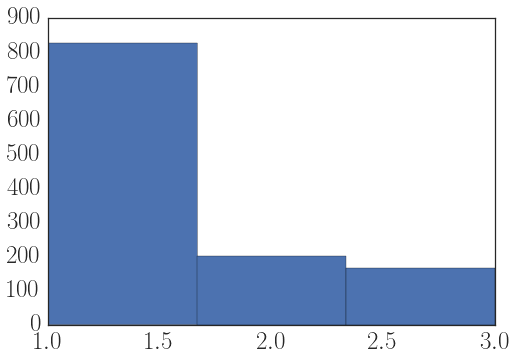

In [64]:
plt.hist(labels, bins=3)

(array([ 402.,  232.,  560.]),
 array([ 1.,  2.,  3.,  4.]),
 <a list of 3 Patch objects>)

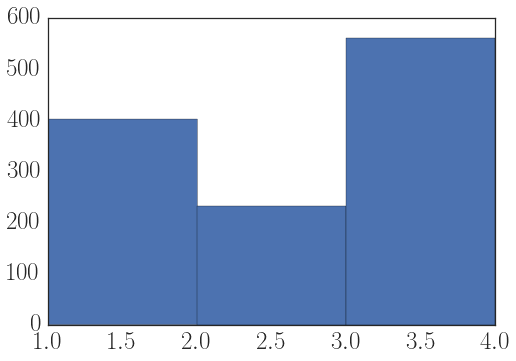

In [65]:
plt.hist(pred_labels, bins=3)

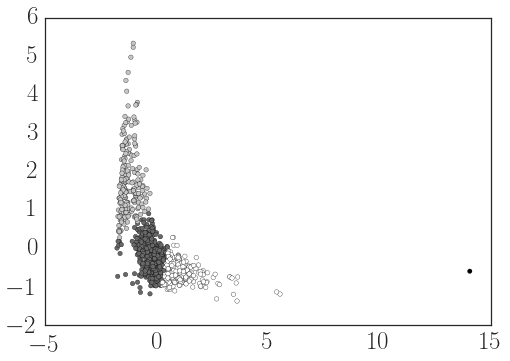

In [66]:
plt.scatter(fscaled[:,0], fscaled[:,1], c=pred_labels)

## Gaussian Mixture Model

Working on the random assumption that our clusters are actually Gaussians, let's make a Gaussian Mixture Model.

In [80]:
data_full = np.loadtxt("asm_ml.txt")
scaler = StandardScaler().fit(data_full)
fscaled = scaler.transform(data_full)

from sklearn import mixture
bic_all = []
rand_all = []

for i in range(15):
    gmm = mixture.GMM(n_components=i+1, covariance_type='full')
    gmm.fit(fscaled)
    Y = gmm.predict(fscaled)
    print(gmm.bic(fscaled))
    #print("Rand Index adjusted for chance: " + str(metrics.adjusted_rand_score(labels, Y)))
    bic_all.append(gmm.bic(fscaled))
    #rand_all.append(metrics.adjusted_rand_score(labels, Y))

532687.84523
122832.799627
37230.6199898
19733.2155547
11697.0269506
7762.28152924
6544.62910888
4238.57083815
3963.92414073
3448.99299916
3125.25484019
3059.71846663
3232.42393748
2958.02616089
3005.20511075


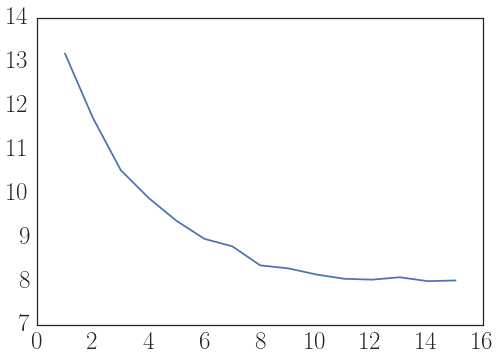

In [83]:
plt.plot(np.arange(len(bic_all))+1., np.log(bic_all))

In [84]:
np.where(np.array(bic_all) == np.min(bic_all))

(array([13]),)

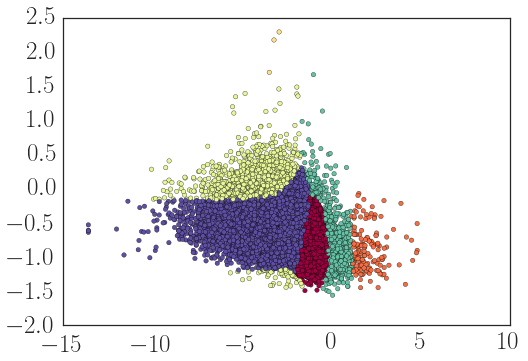

In [86]:
gmm = mixture.GMM(n_components=6, covariance_type='full')
gmm.fit(fscaled)
Y = gmm.predict(fscaled)
plt.scatter(np.log(fscaled[:,0]), fscaled[:,1], c=Y, cmap=plt.cm.Spectral)

In [78]:
hist(Y, bins=6)